In [1]:
import numpy as np
import scanpy as sp
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import sklearn as sk
from sklearn import svm
from sklearn.model_selection import StratifiedKFold, GridSearchCV

seed = 2023 # DO NOT CHANGE!

In [2]:
print(f"sklearn version: {sk.__version__}")
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"scanpy version: {sp.__version__}")

sklearn version: 1.0.1
numpy version: 1.21.3
pandas version: 1.3.4
matplotlib version: 3.4.3
scanpy version: 1.9.1


# Load Data

In [3]:
BMMC = sp.read_h5ad("GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad")

In [4]:
print(f"The data has {BMMC.n_obs} observations and {BMMC.n_vars} features.")

The data has 69249 observations and 129921 features.


In [5]:
BMMC

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [6]:
BMMC.obs['ATAC_atac_fragments']

TAGTTGTCACCCTCAC-1-s1d1      5400
CTATGGCCATAACGGG-1-s1d1     19266
CCGCACACAGGTTAAA-1-s1d1      6177
TCATTTGGTAATGGAA-1-s1d1      4019
ACCACATAGGTGTCCA-1-s1d1      2568
                            ...  
AAACCGCGTTTGAGGC-12-s4d9     9280
TGACTTAAGTTCCCGT-12-s4d9    11980
GCTGTACCACCGTTCC-12-s4d9     7968
ACACTTGCAACTAGAA-12-s4d9    23886
CACTTAAAGTCTGGGC-12-s4d9     5602
Name: ATAC_atac_fragments, Length: 69249, dtype: int32

# Train/Test Split

We choose one donor to train on (te reduce individual biological differences)

In [7]:
BMMC.obs.drop_duplicates(subset=["DonorID"], keep='first').reset_index()[["Site","DonorID","DonorAge","DonorBMI","DonorBloodType","DonorRace","Ethnicity","DonorGender","QCMeds","DonorSmoker"]].set_index('DonorID').sort_values(by=['DonorID'])

,Site,DonorAge,DonorBMI,DonorBloodType,DonorRace,Ethnicity,DonorGender,QCMeds,DonorSmoker
DonorID,,,,,,,,,
10886,site1,35,28.6,B+,Asian,NOT HISPANIC OR LATINO,Female,True,Nonsmoker
11466,site3,22,31.5,A+,Asian,NOT HISPANIC OR LATINO,Female,True,Nonsmoker
12710,site2,27,32.1,O+,White,NOT HISPANIC OR LATINO,Male,False,Nonsmoker
13272,site4,35,31.0,O+,Other Race,HISPANIC OR LATINO,Male,False,Nonsmoker
15078,site1,34,24.8,B-,White,HISPANIC OR LATINO,Male,False,Nonsmoker
16710,site2,40,27.8,O+,White,HISPANIC OR LATINO,Female,False,Smoker
18303,site1,33,24.0,O+,Asian,NOT HISPANIC OR LATINO,Male,False,Smoker
19593,site4,31,32.6,A+,Black or African American,NOT HISPANIC OR LATINO,Male,False,Nonsmoker
28045,site3,36,23.8,A+,Other Race,HISPANIC OR LATINO,Female,False,Nonsmoker


69249 samples of 10 donors


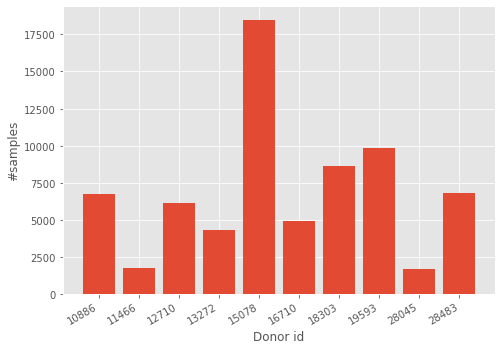

In [8]:
donors, donor_sample_count = np.unique(BMMC.obs['DonorID'], return_counts=True)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
print(f"{np.sum(donor_sample_count)} samples of {len(donors)} donors")
ax.bar(list(map(str, donors)), donor_sample_count)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Donor id")
plt.ylabel("#samples")
plt.show()

In [9]:
donor_idx = 15078 # most samples

donor_filter = BMMC.obs['DonorID'] == donor_idx
n_samples = np.sum(donor_filter)

print(f"{n_samples} samples")

18467 samples


In [10]:
# Random 70-30 split
train_percentage = 0.7

np.random.seed(seed)
train_samples_idx = np.random.choice(n_samples, int(n_samples*train_percentage), replace=False)
test_samples_idx = np.delete(np.arange(n_samples), train_samples_idx)

X_test = BMMC.obsm['ATAC_gene_activity'][donor_filter][test_samples_idx]
X_train = BMMC.obsm['ATAC_gene_activity'][donor_filter][train_samples_idx]

Y_test = BMMC.obs['cell_type'][donor_filter][test_samples_idx]
Y_train = BMMC.obs['cell_type'][donor_filter][train_samples_idx]

In [11]:
Y_train

AGAGAAGCAATAGTCT-13-s4d1     Proerythroblast
CCGCTTAGTTCCGGCT-1-s1d1     CD4+ T activated
GTCCATTGTGGGTACT-13-s4d1    CD4+ T activated
GCTGATCCACCTAATG-1-s1d1           CD14+ Mono
CTTCAAGCAATAACGA-1-s1d1           CD14+ Mono
                                  ...       
TTCATTCAGCTTTGTT-13-s4d1         Plasma cell
TTCACTGTCTAGCGAT-4-s2d1         Erythroblast
ATTAGCTCATGAATCT-1-s1d1         Erythroblast
ACTGAATGTATACTGG-13-s4d1                  NK
TTTGTTGGTCCACAAA-4-s2d1        Naive CD20+ B
Name: cell_type, Length: 12926, dtype: category
Categories (22, object): ['B1 B', 'CD4+ T activated', 'CD4+ T naive', 'CD8+ T', ..., 'Proerythroblast', 'Transitional B', 'cDC2', 'pDC']

# Data visualistion

In [12]:
cell_types = np.unique(BMMC.obs['cell_type'])
print(cell_types)

['B1 B' 'CD14+ Mono' 'CD16+ Mono' 'CD4+ T activated' 'CD4+ T naive'
 'CD8+ T' 'CD8+ T naive' 'Erythroblast' 'G/M prog' 'HSC'
 'ID2-hi myeloid prog' 'ILC' 'Lymph prog' 'MK/E prog' 'NK' 'Naive CD20+ B'
 'Normoblast' 'Plasma cell' 'Proerythroblast' 'Transitional B' 'cDC2'
 'pDC']


In [24]:
list(set(cell_types) - set(main_cell_types_mapping.keys()))

['MK/E prog', 'ILC', 'HSC', 'NK', 'Lymph prog']

In [25]:
main_cell_types_mapping

{'B1 B': 'B Cells',
 'Naive CD20+ B': 'B Cells',
 'Transitional B': 'B Cells',
 'Plasma cell': 'B Cells',
 'CD4+ T activated': 'T Cells',
 'CD4+ T naive': 'T Cells',
 'CD8+ T': 'T Cells',
 'CD8+ T naive': 'T Cells',
 'CD14+ Mono': 'Monocytes/Macrophages',
 'CD16+ Mono': 'Monocytes/Macrophages',
 'G/M prog': 'Myeloid Progenitors',
 'ID2-hi myeloid prog': 'Myeloid Progenitors',
 'Erythroblast': 'Erythroid Cells',
 'Normoblast': 'Erythroid Cells',
 'Proerythroblast': 'Erythroid Cells',
 'cDC2': 'Dendritic cells',
 'pDC': 'Dendritic cells'}

In [29]:
main_cell_types = {
    'B Cells': ['B1 B', 'Naive CD20+ B', 'Transitional B', 'Plasma cell'],
    'T Cells': ['CD4+ T activated', 'CD4+ T naive', 'CD8+ T', 'CD8+ T naive'],
    'Monocytes/Macrophages': ['CD14+ Mono', 'CD16+ Mono'],
    'Myeloid Progenitors': ['G/M prog' , 'ID2-hi myeloid prog'],
    'Erythroid Cells': ['Erythroblast', 'Normoblast', 'Proerythroblast'],
    'Dendritic cells': ['cDC2', 'pDC']
}

main_cell_types_mapping = {x:k for k,v in main_cell_types.items() for x in v}
missing_cell_types = list(set(cell_types) - set(main_cell_types_mapping.keys()))
missing_cell_types.sort()
for missing_cell_type in missing_cell_types:
    main_cell_types_mapping[missing_cell_type] = missing_cell_type
main_cell_types_mapping

cell_types_sorted = np.concatenate((np.array([x for k,v in main_cell_types.items() for x in v]), np.array(missing_cell_types)))
cell_types_sorted

array(['B1 B', 'Naive CD20+ B', 'Transitional B', 'Plasma cell',
       'CD4+ T activated', 'CD4+ T naive', 'CD8+ T', 'CD8+ T naive',
       'CD14+ Mono', 'CD16+ Mono', 'G/M prog', 'ID2-hi myeloid prog',
       'Erythroblast', 'Normoblast', 'Proerythroblast', 'cDC2', 'pDC',
       'HSC', 'ILC', 'Lymph prog', 'MK/E prog', 'NK'], dtype='<U19')

12926 samples of 21 cells


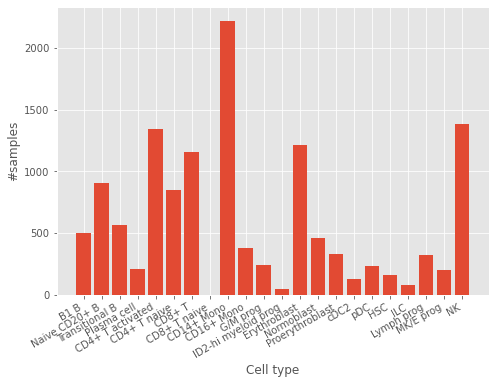

In [30]:
cells, counts = np.unique(Y_train, return_counts=True)
print(f"{np.sum(counts)} samples of {len(cells)} cells")
for missing_celltype in set(cell_types) - set(cells):
    cells = np.append(cells, missing_celltype)
    counts = np.append(counts, 0)

sorted_counts = counts[[np.where(np.isin(cells, c))[0][0] for c in cell_types_sorted]]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(cell_types_sorted, sorted_counts)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Cell type")
plt.ylabel("#samples")
plt.show()

In [31]:
X_train

<12926x19039 sparse matrix of type '<class 'numpy.float32'>'
	with 66331388 stored elements in Compressed Sparse Column format>

In [32]:
print(f"The sparsity of the train matrix is {(1 - 66331388 / (X_train.shape[0] * X_train.shape[1])) * 100:.2f}%")

The sparsity of the train matrix is 73.05%


In [33]:
# TODO add more data visualisation

# Model Training

In [17]:
n_folds = 5 # change?

cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state = seed)

param_grid = {
    'C': [0.001]
}

lsvc = svm.LinearSVC()
gridsearch = GridSearchCV(lsvc, param_grid, n_jobs=-1, cv=cv, verbose=5, 
                          return_train_score=True)

gridsearch.fit(X_train, Y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END .......C=0.001;, score=(train=1.000, test=0.880) total time=  30.9s
[CV 2/5] END .......C=0.001;, score=(train=1.000, test=0.874) total time=  31.0s
[CV 3/5] END .......C=0.001;, score=(train=1.000, test=0.880) total time=  31.0s
[CV 4/5] END .......C=0.001;, score=(train=1.000, test=0.867) total time=  30.5s
[CV 5/5] END .......C=0.001;, score=(train=1.000, test=0.869) total time=  30.6s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2023, shuffle=True),
             estimator=LinearSVC(), n_jobs=-1, param_grid={'C': [0.001]},
             return_train_score=True, verbose=5)

In [18]:
results = gridsearch.cv_results_
train_score = results['mean_train_score'][gridsearch.best_index_]
validation_score = results['mean_test_score'][gridsearch.best_index_]

print(f'Average training accuracy across folds: {train_score:.3}')
print(f'Average validation accuracy across folds: {validation_score:.3}')

print(f'Best hyperparams: {gridsearch.best_params_}')

Average training accuracy across folds: 1.0
Average validation accuracy across folds: 0.874
Best hyperparams: {'C': 0.001}


In [20]:
# save best model
with open('lsvm_best_model_singledonor.pkl','wb') as f:
    pickle.dump(gridsearch.best_estimator_,f)

# Model Analysis

In [34]:
# load model
with open('lsvm_best_model_singledonor.pkl', 'rb') as f:
    best_model = pickle.load(f)

In [35]:
test_predictions =  best_model.predict(X_test)
test_predictions

array(['CD14+ Mono', 'CD8+ T', 'B1 B', ..., 'NK', 'NK',
       'CD4+ T activated'], dtype=object)

In [36]:
Y_test

CTATGGCCATAACGGG-1-s1d1           CD14+ Mono
TCATTTGGTAATGGAA-1-s1d1               CD8+ T
GTAAGGTCAATAACCT-1-s1d1                 B1 B
TGCCGGTAGTCGCAAT-1-s1d1           CD14+ Mono
CATCCCAGTCTTTATG-1-s1d1           CD14+ Mono
                                  ...       
CTCACAACACAACAGG-13-s4d1          CD14+ Mono
CATCATAAGGACCTCA-13-s4d1              CD8+ T
CGAACAAAGGATAAAC-13-s4d1                  NK
GTAATAGCACCTGGTG-13-s4d1                  NK
CTGTGTGAGCGGGCAA-13-s4d1    CD4+ T activated
Name: cell_type, Length: 5541, dtype: category
Categories (22, object): ['B1 B', 'CD4+ T activated', 'CD4+ T naive', 'CD8+ T', ..., 'Proerythroblast', 'Transitional B', 'cDC2', 'pDC']

In [37]:
train_predictions =  best_model.predict(X_train)
train_predictions

array(['Proerythroblast', 'CD4+ T activated', 'CD4+ T activated', ...,
       'Erythroblast', 'NK', 'Naive CD20+ B'], dtype=object)

In [38]:
from sklearn.metrics import accuracy_score

print(f"Train accuracy: {accuracy_score(Y_train, train_predictions)}")
print(f"Test accuracy: {accuracy_score(Y_test, test_predictions)}")

Train accuracy: 0.9999226365464954
Test accuracy: 0.8846778559826746


In [39]:
from sklearn.metrics import balanced_accuracy_score

print(f"Balanced Train Accuracy: {balanced_accuracy_score(Y_train, train_predictions)}")
print(f"Balanced Test Accuracy: {balanced_accuracy_score(Y_test, test_predictions)}")

Balanced Train Accuracy: 0.9999589136776367
Balanced Test Accuracy: 0.7713595311871705


In [40]:
all_predictions = best_model.predict(BMMC.obsm['ATAC_gene_activity'][donor_filter])
all_labels = BMMC.obs['cell_type'][donor_filter]
all_predictions

array(['Naive CD20+ B', 'CD14+ Mono', 'CD8+ T', ..., 'CD4+ T activated',
       'Plasma cell', 'CD4+ T activated'], dtype=object)

In [41]:
print(f"Donor {donor_idx} Accuracy Score: {accuracy_score(all_labels, all_predictions)}")
print(f"Balanced Donor {donor_idx} Accuracy Score: {balanced_accuracy_score(all_labels, all_predictions)}")

Donor 15078 Accuracy Score: 0.965343585855851
Balanced Donor 15078 Accuracy Score: 0.9293111258427673


In [46]:
whole_dataset_predictions = best_model.predict(BMMC.obsm['ATAC_gene_activity'])
whole_dataset_labels = BMMC.obs['cell_type']

In [47]:
print(f"All Donors Accuracy Score: {accuracy_score(whole_dataset_labels, whole_dataset_predictions)}")
print(f"Balanced All Donors Accuracy Score: {balanced_accuracy_score(whole_dataset_labels, whole_dataset_predictions)}")

All Donors Accuracy Score: 0.8249072188768068
Balanced All Donors Accuracy Score: 0.7151631389093589


In [42]:
X_train

<12926x19039 sparse matrix of type '<class 'numpy.float32'>'
	with 66331388 stored elements in Compressed Sparse Column format>

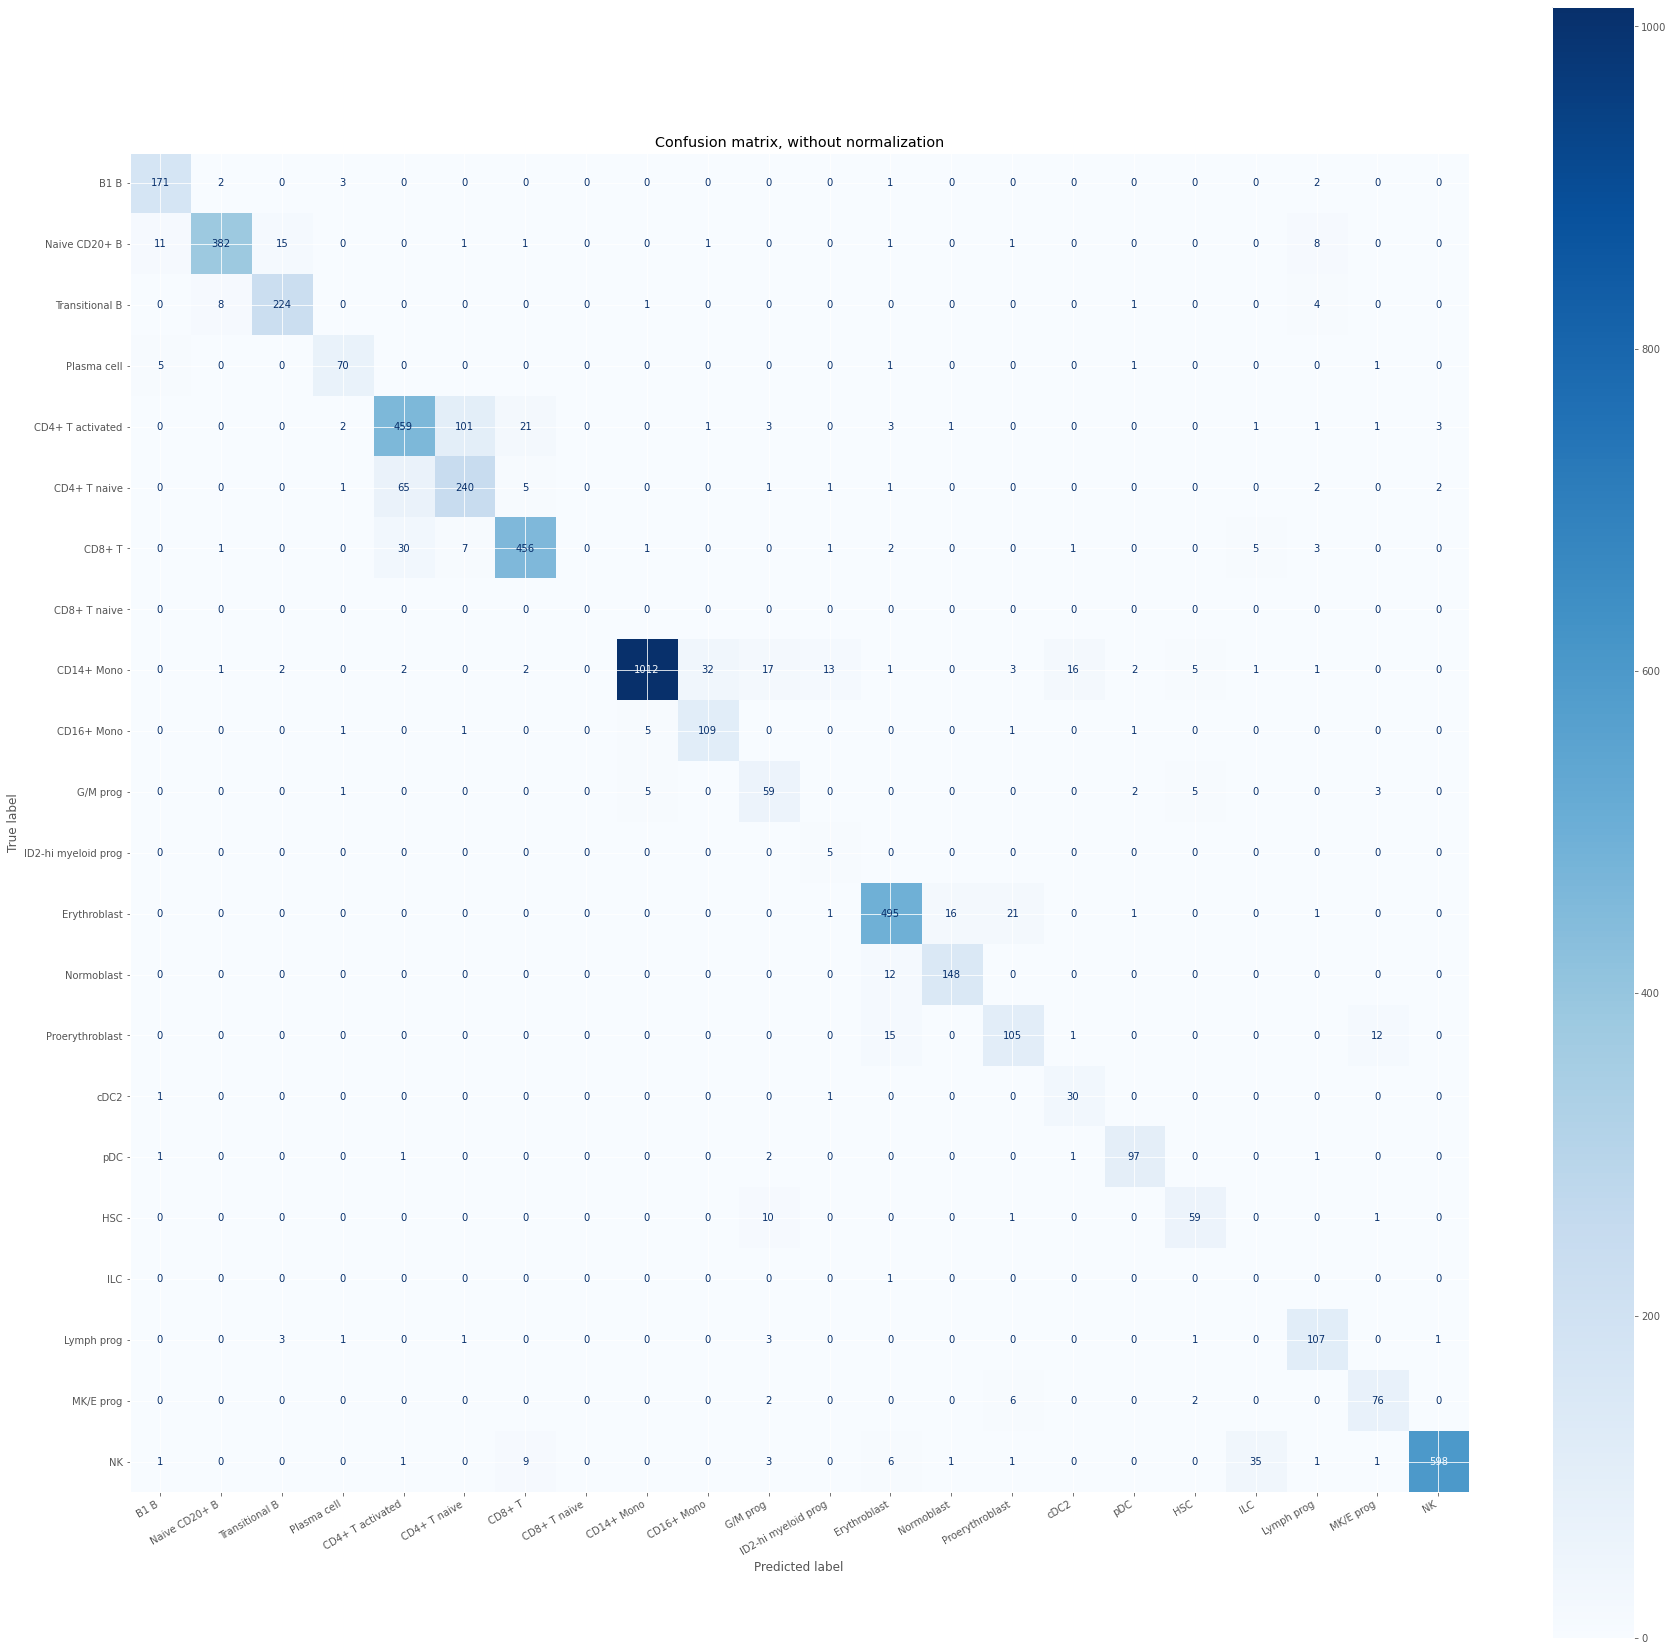

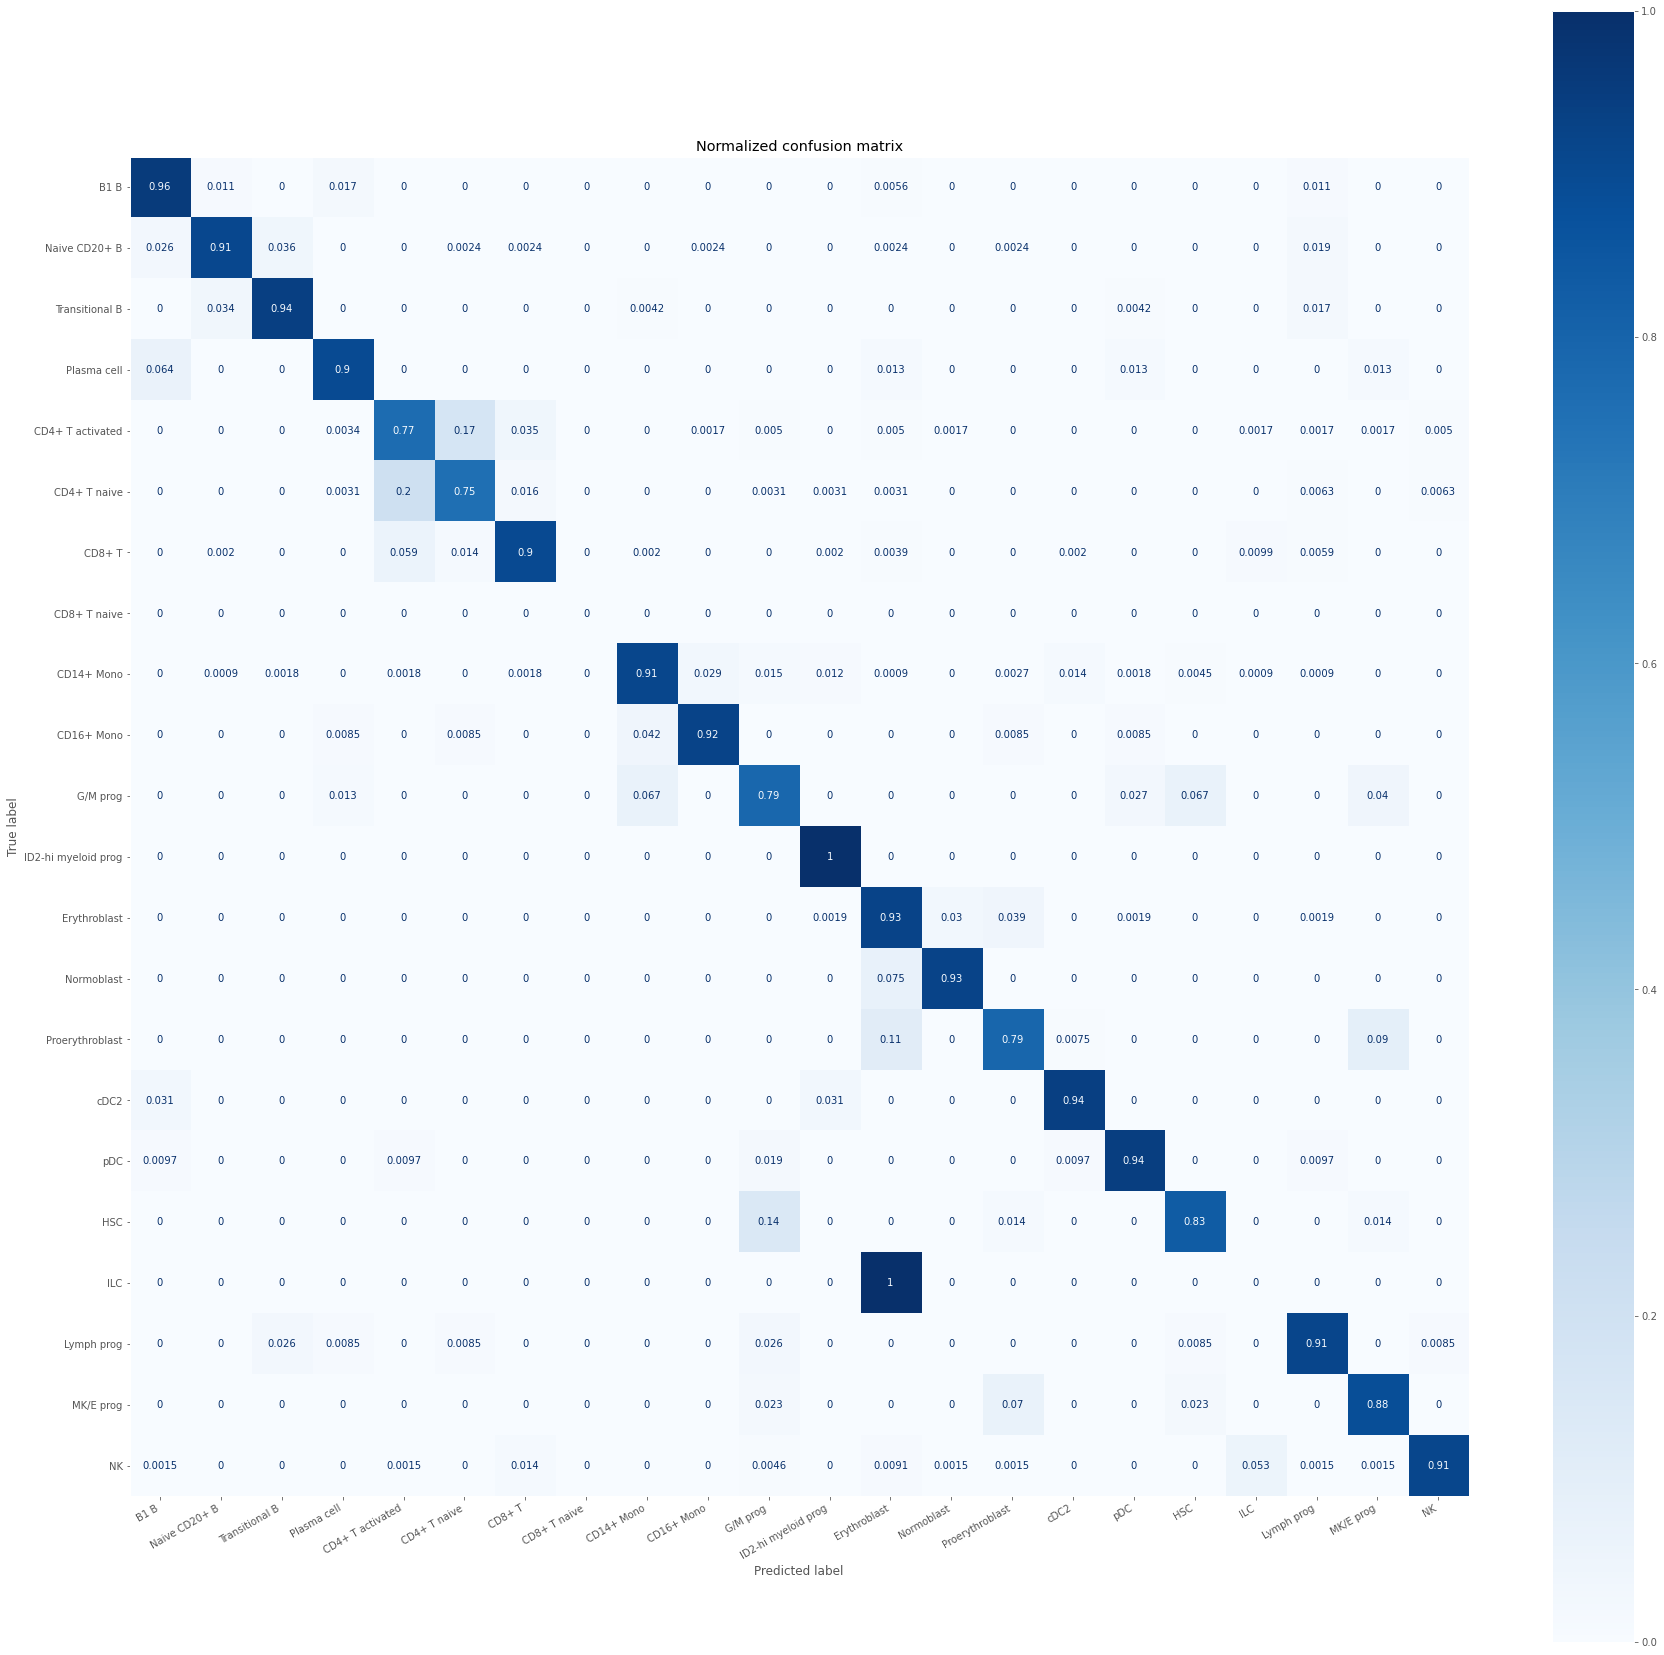

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
plt.rcParams['figure.figsize'] = [30, 30]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_predictions(
        test_predictions,
        Y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
        labels=cell_types_sorted
    )
    plt.xticks(rotation=30, ha='right')
    disp.ax_.set_title(title)
    

plt.grid(False)
plt.show()

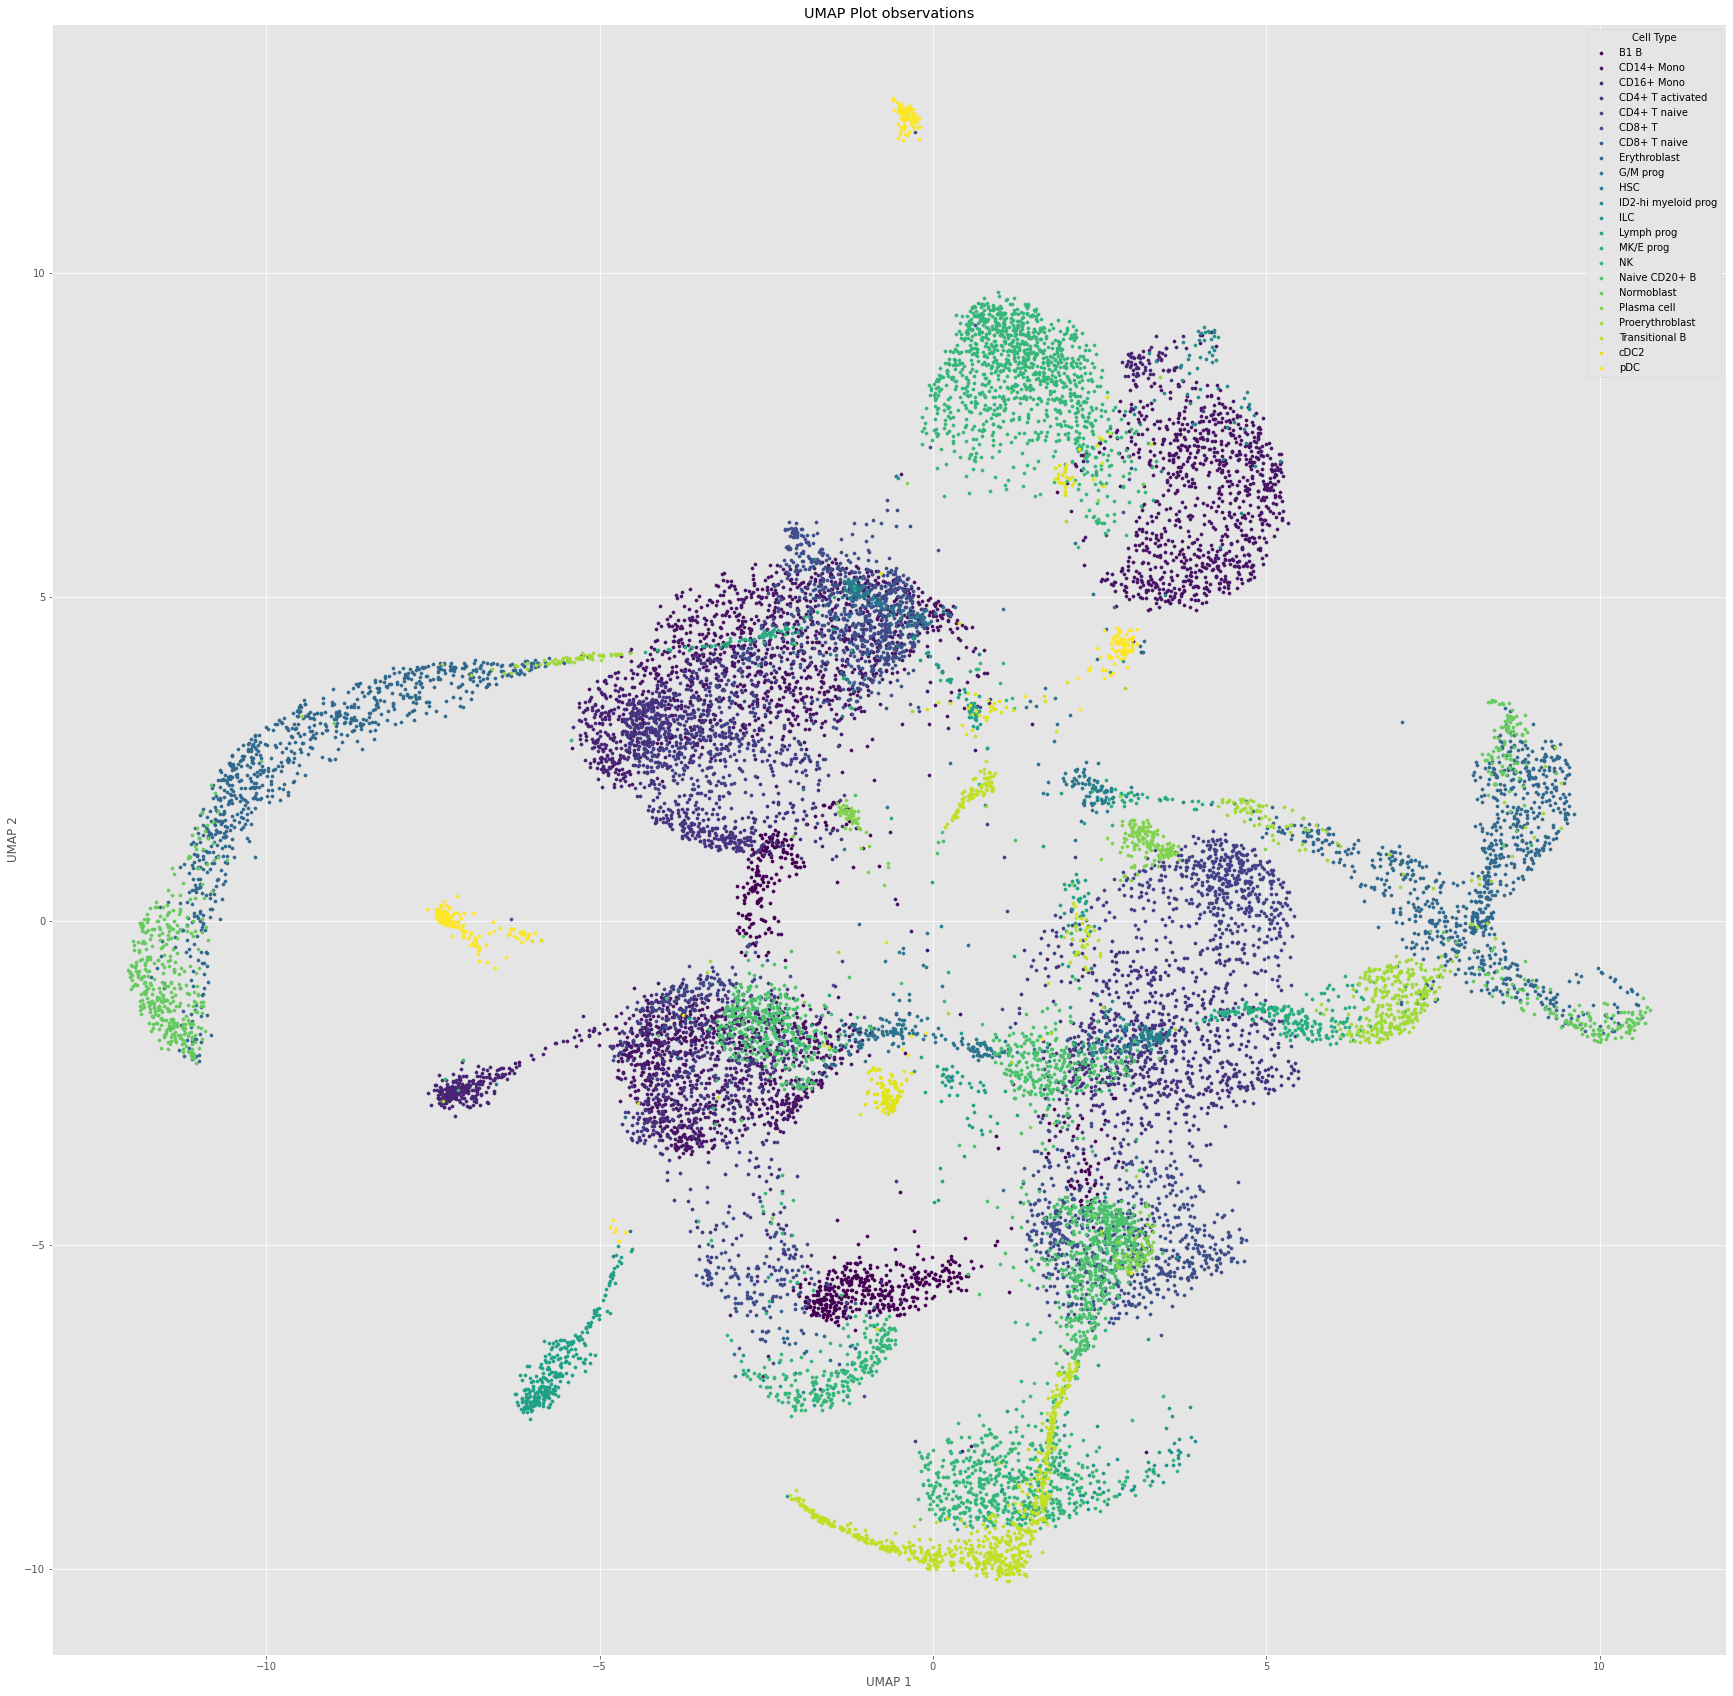

In [32]:
umap_coordinates = BMMC.obsm['ATAC_umap'][donor_filter]

cell_types = np.unique(BMMC.obs['cell_type'])
colors = plt.cm.get_cmap('viridis', len(cell_types))

for i, cell_type in enumerate(cell_types):
    mask = (BMMC.obs['cell_type'][donor_filter] == cell_type)
    plt.scatter(umap_coordinates[mask, 0], umap_coordinates[mask, 1], label=cell_type, color=colors(i), s=10)
    
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Plot observations')
plt.legend(title='Cell Type')
plt.show()

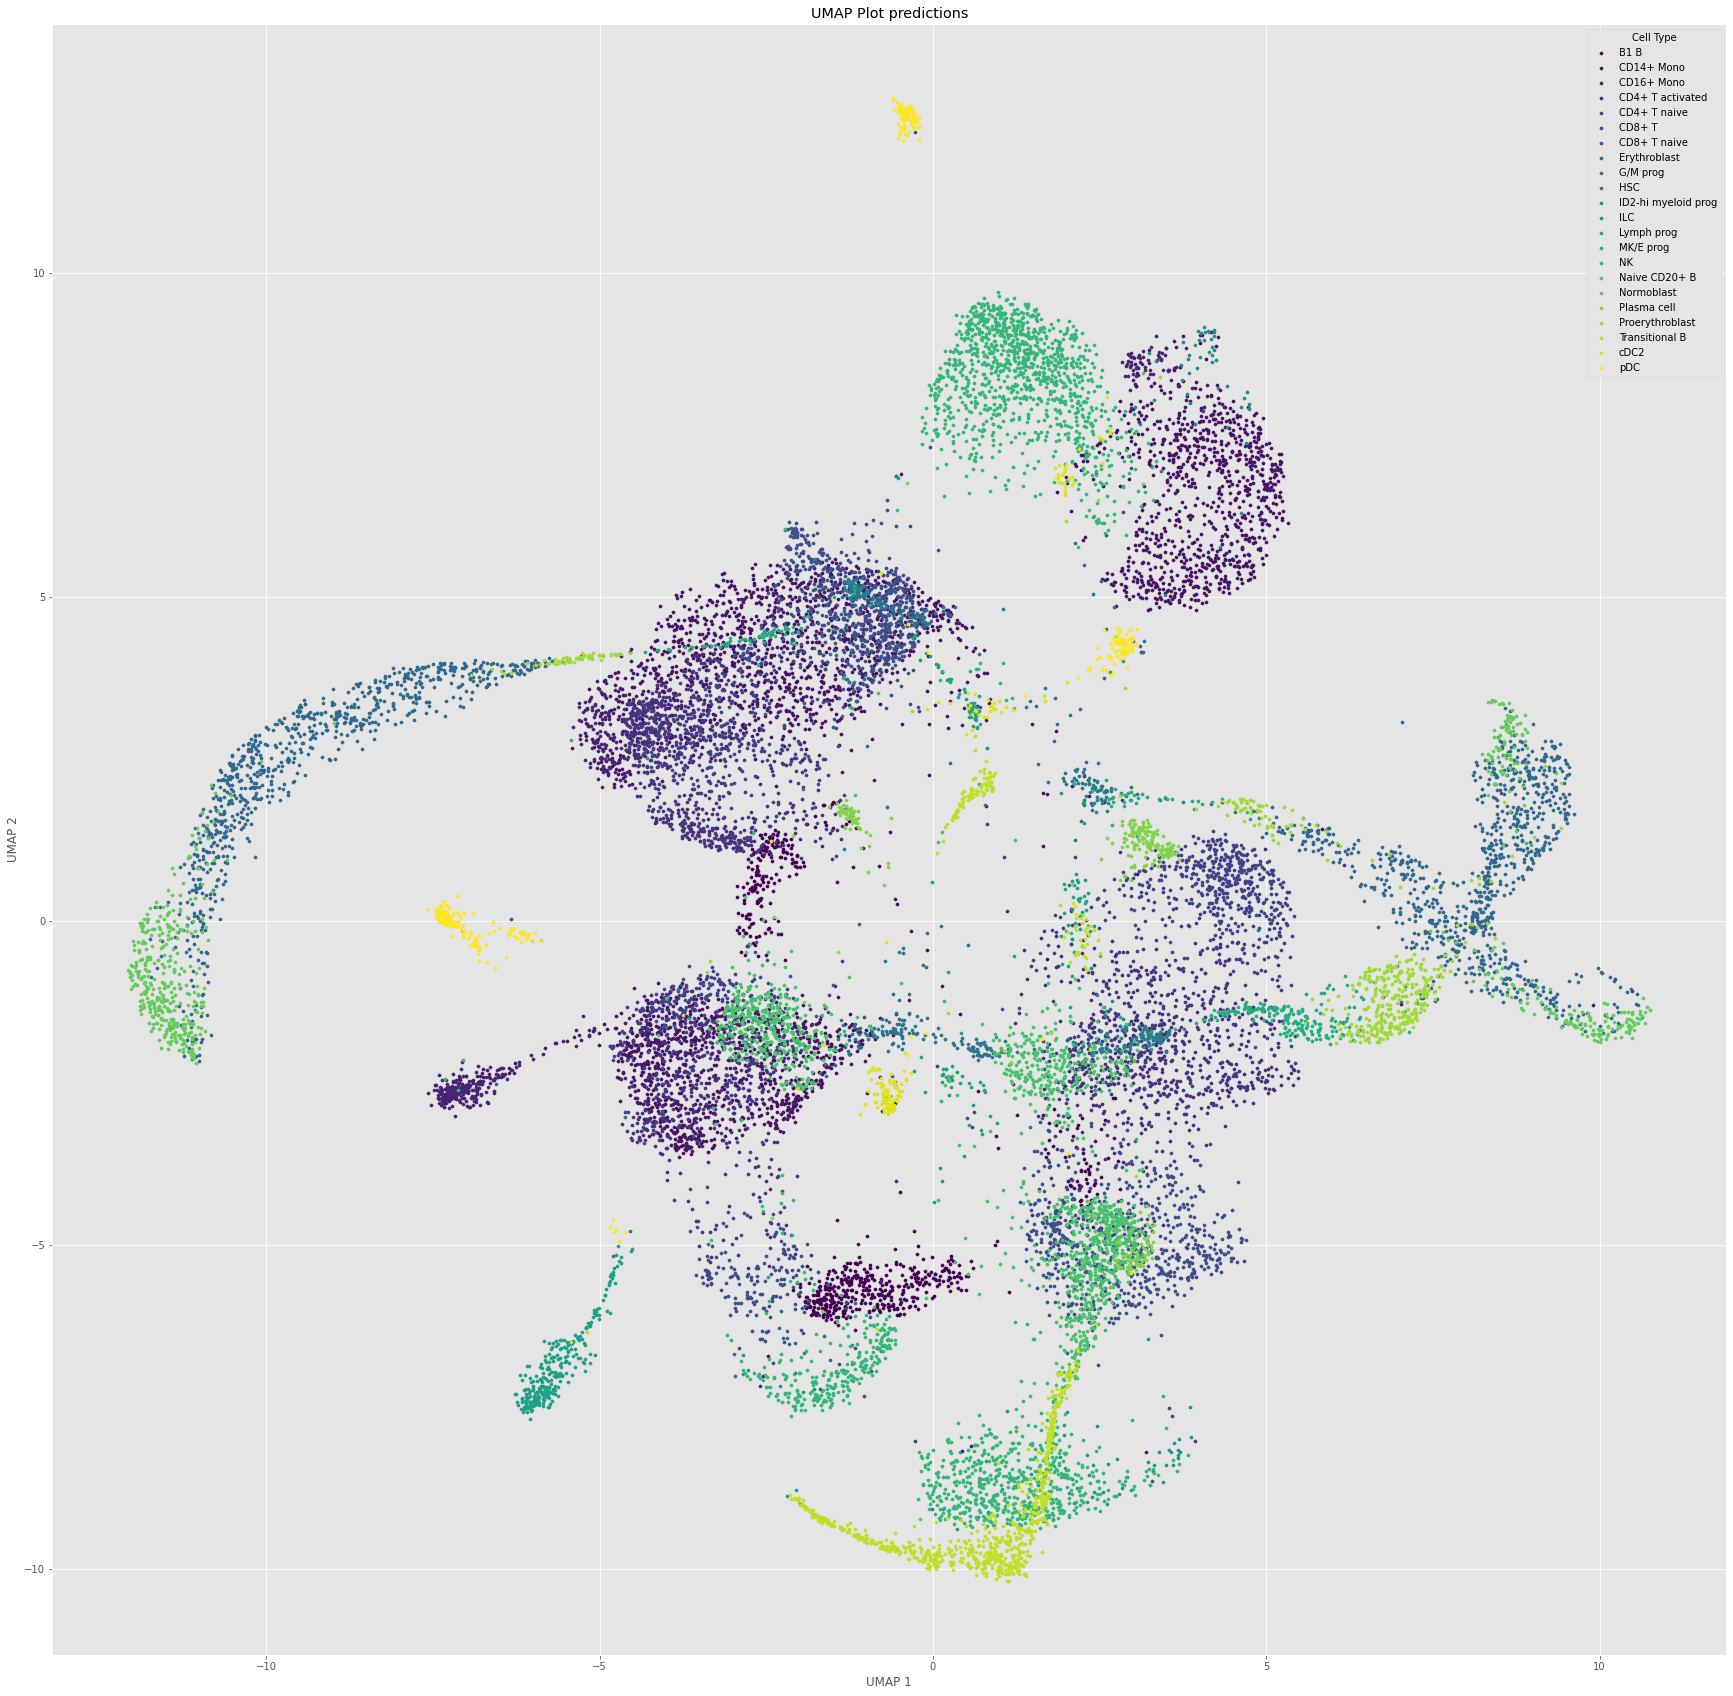

In [33]:
for i, cell_type in enumerate(cell_types):
    mask = (all_predictions == cell_type)
    plt.scatter(umap_coordinates[mask, 0], umap_coordinates[mask, 1], label=cell_type, color=colors(i), s=10)
    
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Plot predictions')
plt.legend(title='Cell Type')
plt.show()

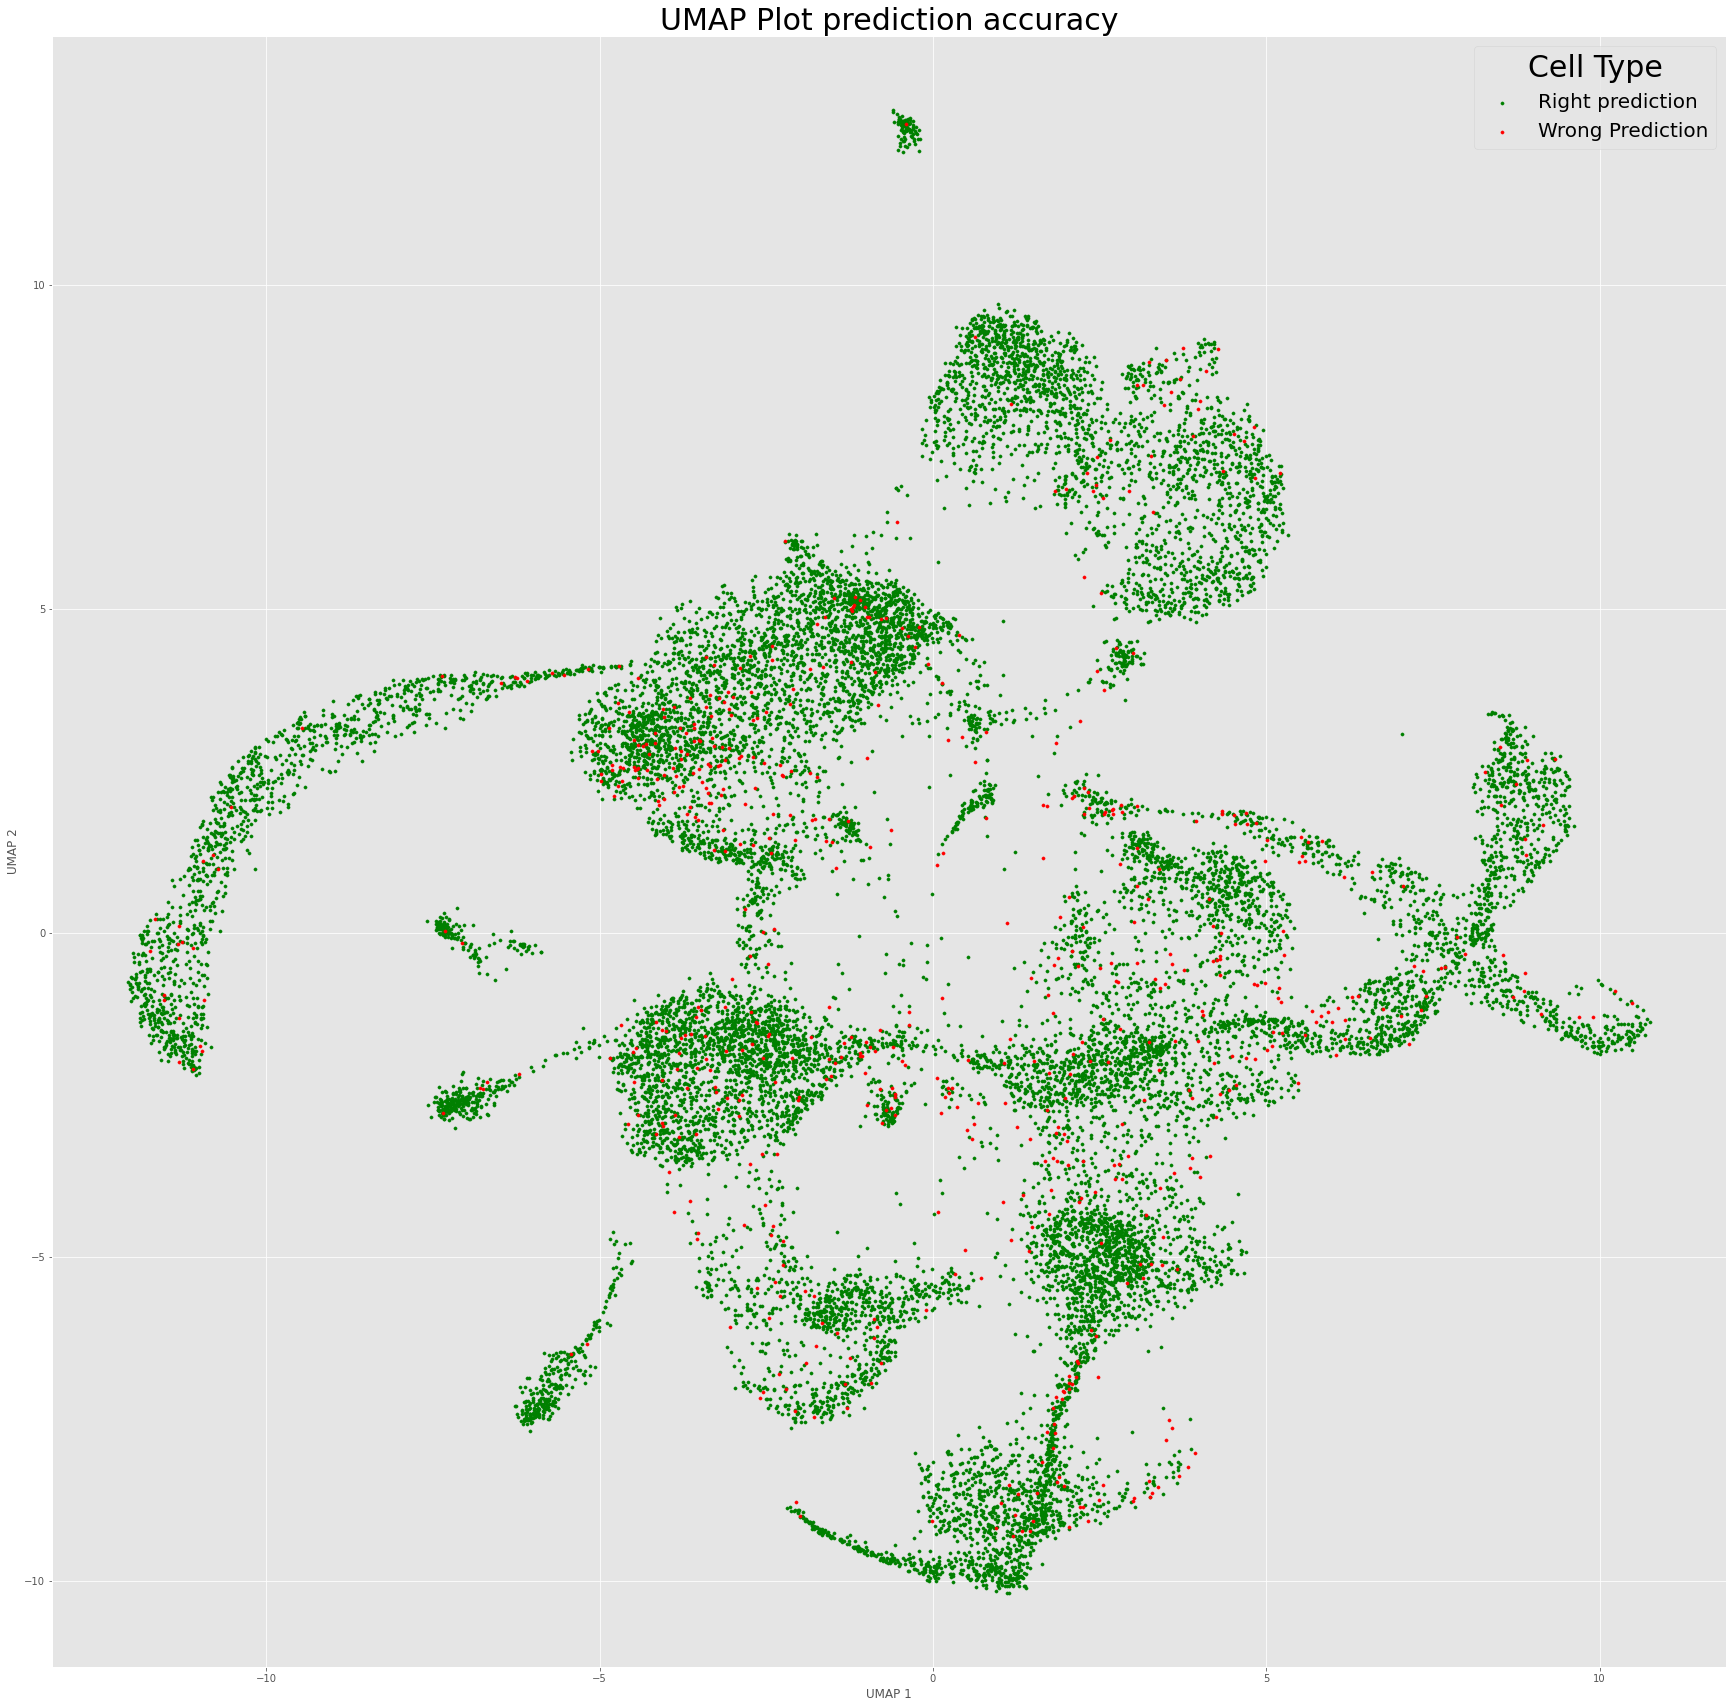

In [34]:
RightPred_mask = (all_predictions == BMMC.obs['cell_type'][donor_filter])
plt.scatter(umap_coordinates[RightPred_mask, 0], umap_coordinates[RightPred_mask, 1], label="Right prediction", color='green', s=10)
plt.scatter(umap_coordinates[np.invert(RightPred_mask), 0], umap_coordinates[np.invert(RightPred_mask), 1], label="Wrong Prediction", color='red', s=10)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Plot prediction accuracy', fontsize=30)
plt.legend(title='Cell Type', fontsize=20, title_fontsize=30)
plt.show()

In [35]:
main_cell_types = {
    'B Cells': ['B1 B', 'Naive CD20+ B', 'Transitional B', 'Plasma cell'],
    'T Cells': ['CD4+ T activated', 'CD4+ T naive', 'CD8+ T', 'CD8+ T naive'],
    'Monocytes/Macrophages': ['CD14+ Mono', 'CD16+ Mono'],
    'Myeloid Progenitors': ['G/M prog' , 'ID2-hi myeloid prog'],
    'Erythroid Cells': ['Erythroblast', 'Normoblast', 'Proerythroblast'],
    'Dendritic cells': ['cDC2', 'pDC']
}

main_cell_types_mapping = {x:k for k,v in main_cell_types.items() for x in v}
for missing_cell_type in set(cell_types) - set(main_cell_types_mapping.keys()):
    main_cell_types_mapping[missing_cell_type] = missing_cell_type
main_cell_types_mapping

{'B1 B': 'B Cells',
 'Naive CD20+ B': 'B Cells',
 'Transitional B': 'B Cells',
 'Plasma cell': 'B Cells',
 'CD4+ T activated': 'T Cells',
 'CD4+ T naive': 'T Cells',
 'CD8+ T': 'T Cells',
 'CD8+ T naive': 'T Cells',
 'CD14+ Mono': 'Monocytes/Macrophages',
 'CD16+ Mono': 'Monocytes/Macrophages',
 'G/M prog': 'Myeloid Progenitors',
 'ID2-hi myeloid prog': 'Myeloid Progenitors',
 'Erythroblast': 'Erythroid Cells',
 'Normoblast': 'Erythroid Cells',
 'Proerythroblast': 'Erythroid Cells',
 'cDC2': 'Dendritic cells',
 'pDC': 'Dendritic cells',
 'ILC': 'ILC',
 'MK/E prog': 'MK/E prog',
 'HSC': 'HSC',
 'NK': 'NK',
 'Lymph prog': 'Lymph prog'}

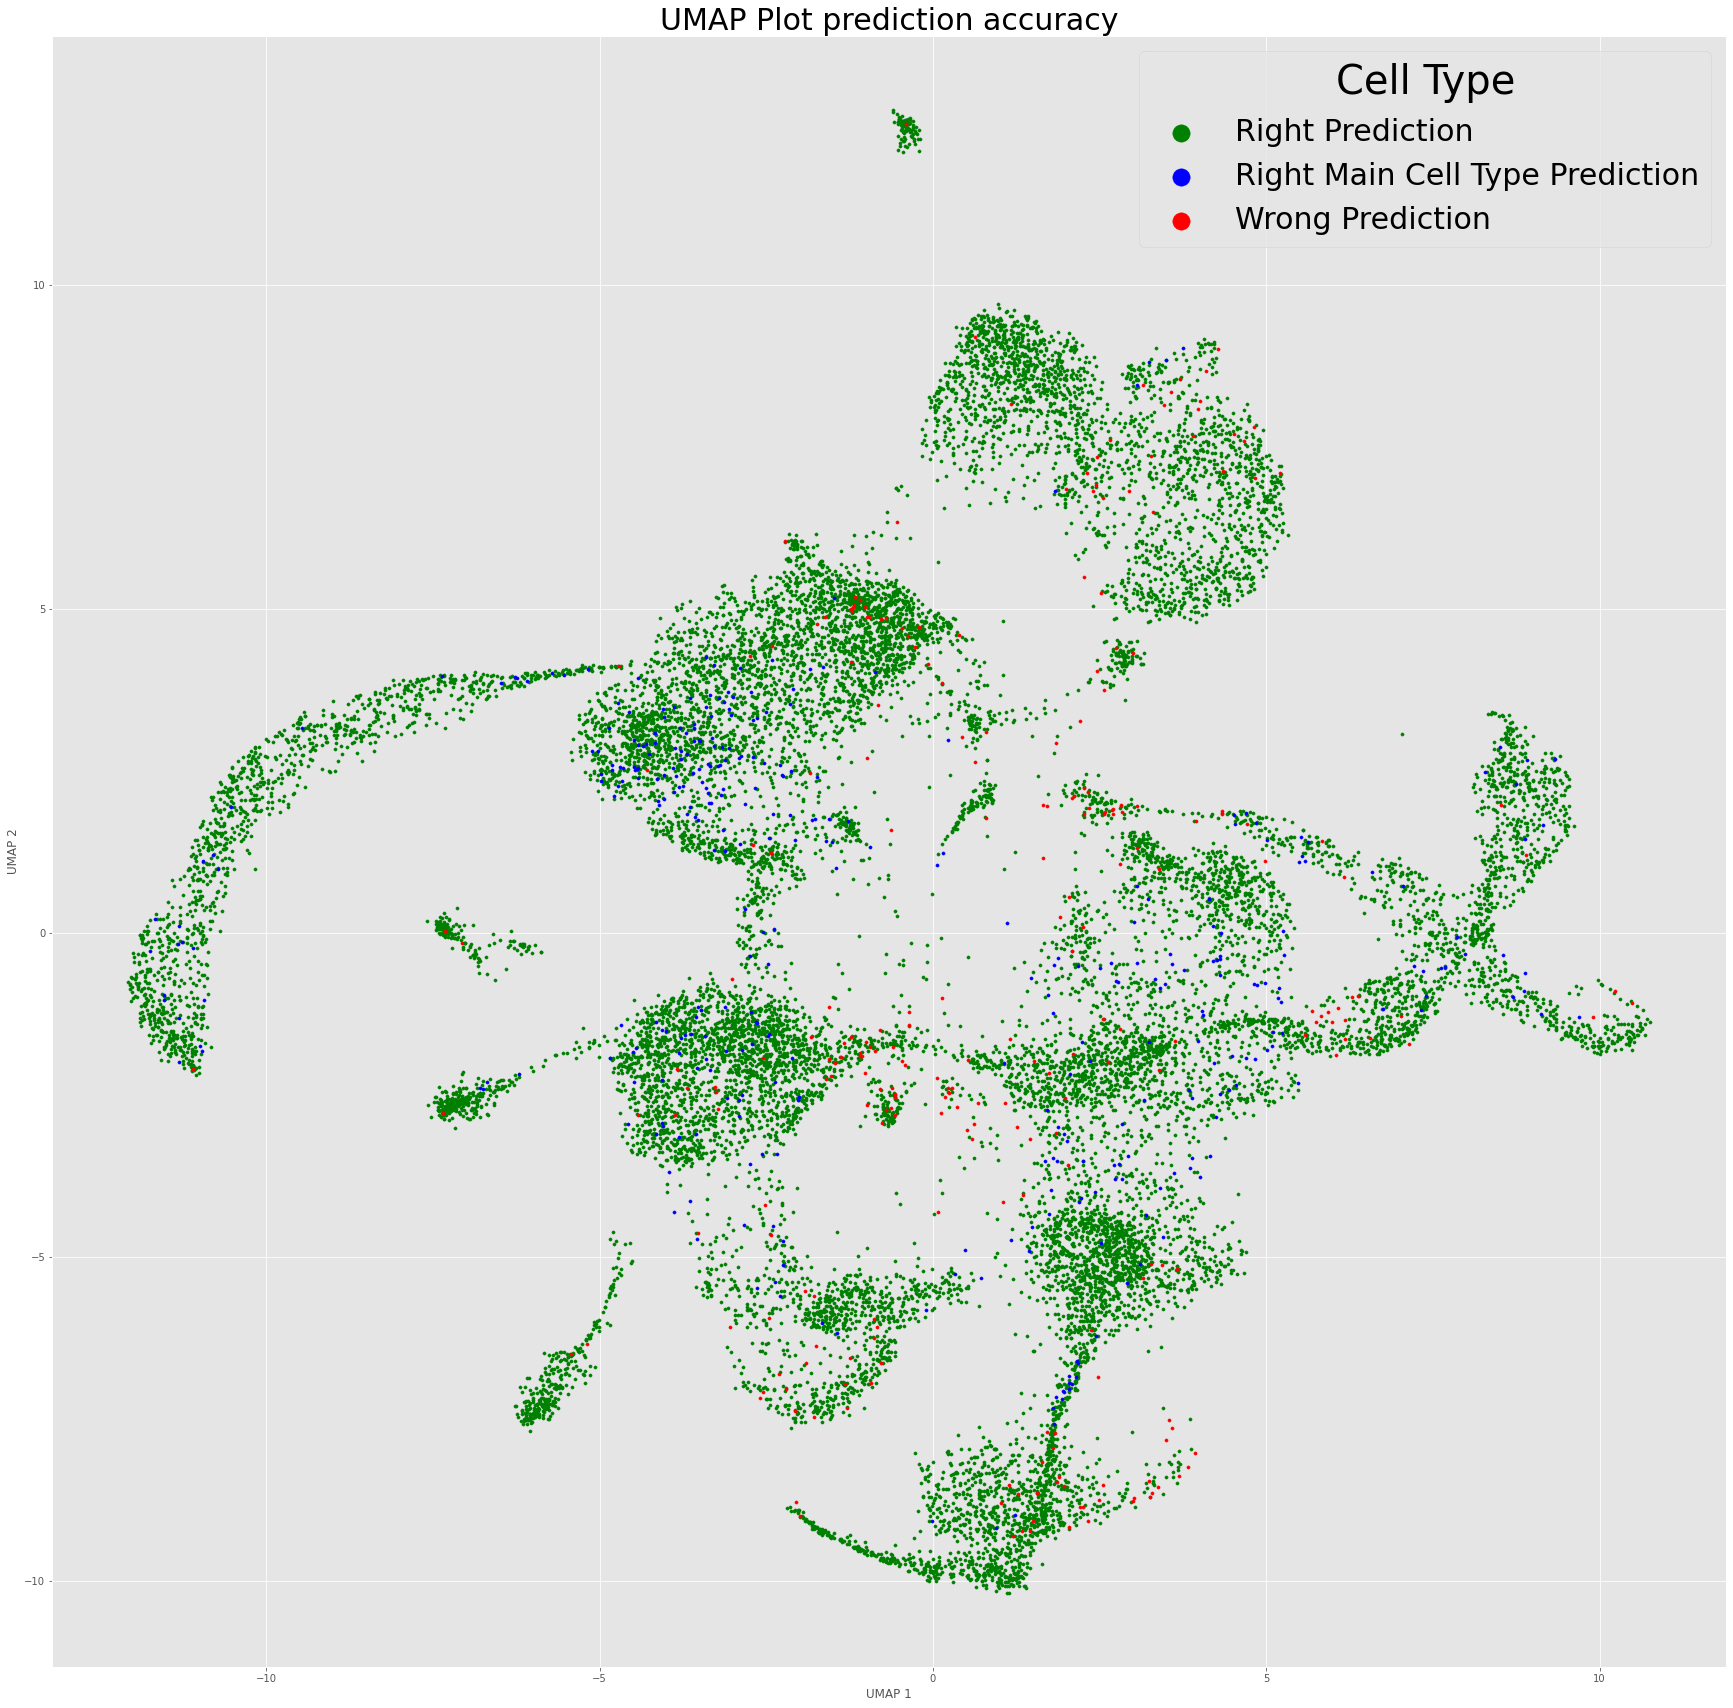

In [36]:
RightPred_mask = (all_predictions == BMMC.obs['cell_type'][donor_filter])
MainCellTypePred_mask = np.logical_and(
(np.vectorize(main_cell_types_mapping.get)(all_predictions) == np.vectorize(main_cell_types_mapping.get)(BMMC.obs['cell_type'][donor_filter])),
np.invert(RightPred_mask)
)
WrongPred_Mask = np.invert(np.logical_or(RightPred_mask, MainCellTypePred_mask))

plt.scatter(umap_coordinates[RightPred_mask, 0], umap_coordinates[RightPred_mask, 1], label="Right Prediction", color='green', s=10)
plt.scatter(umap_coordinates[MainCellTypePred_mask, 0], umap_coordinates[MainCellTypePred_mask, 1], label="Right Main Cell Type Prediction", color='blue', s=10)
plt.scatter(umap_coordinates[WrongPred_Mask, 0], umap_coordinates[WrongPred_Mask, 1], label="Wrong Prediction", color='red', s=10)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Plot prediction accuracy', fontsize=30)
l = plt.legend(title='Cell Type', fontsize=30, title_fontsize=40)
for legendHandle in l.legendHandles:
    legendHandle._sizes = [300]
plt.show()